In [25]:
from rtlsdr import RtlSdr
import rtlsdr.rtlsdrtcp as rsts
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import csv
import time
import math

In [ ]:
sdr = rsts.client.RtlSdrTcpClient(hostname='192.168.113.249', port=1234)
sdr.set_sample_rate(1.96e5) # Hz
sdr.set_center_freq(92.7e6)   # Hz
sdr.set_freq_correction(60)  # PPM

print(len(sdr.read_samples(1024)))
sdr.close()

ConnectionRefusedError: [Errno 111] Connection refused

Detached kernel driver
Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


[0.0, 0.9, 1.4, 2.7, 3.7, 7.7, 8.7, 12.5, 14.4, 15.7, 16.6, 19.7, 20.7, 22.9, 25.4, 28.0, 29.7, 32.8, 33.8, 36.4, 37.2, 38.6, 40.2, 42.1, 43.4, 43.9, 44.5, 48.0, 49.6]
49.6


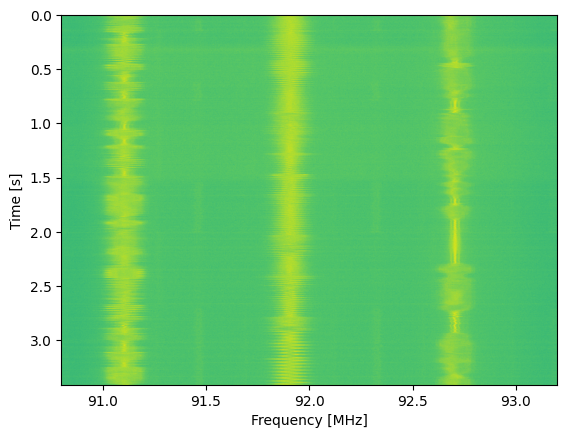

Reattached kernel driver


In [14]:

sdr = RtlSdr()
sdr.sample_rate = 2.4e6 # Hz
sdr.center_freq = 92.0e6   # Hz
sdr.freq_correction = 60  # PPM
print(sdr.valid_gains_db)
sdr.gain = 49.6
print(sdr.gain)
fft_size = 1024
num_rows = 8000
#x = sdr.read_samples(2048*2400) # set how mnay samples to listen to
x = sdr.read_samples(fft_size*num_rows) # get all the samples we need for the spectrogram
spectrogram = np.zeros((num_rows, fft_size))
for i in range(num_rows):
    spectrogram[i,:] = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x[i*fft_size:(i+1)*fft_size])))**2)
extent = [(sdr.center_freq + sdr.sample_rate/-2)/1e6,
            (sdr.center_freq + sdr.sample_rate/2)/1e6,
            len(x)/sdr.sample_rate, 0]
plt.imshow(spectrogram, aspect='auto', extent=extent)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")
plt.show()
sdr.close()


In [16]:
spect_df = pd.DataFrame(spectrogram)
#spect_df.to_csv("spectrogram4.csv")

In [17]:
interval_width = 5
num_intervals = int(num_rows/interval_width)
mean_vals = np.zeros((num_intervals, 1))

for i in range(0,num_rows,interval_width):
    mean_vals[int(i/interval_width)] = spect_df.iloc[i:i+interval_width].values.mean()


Text(0, 0.5, 'energy (in dB)')

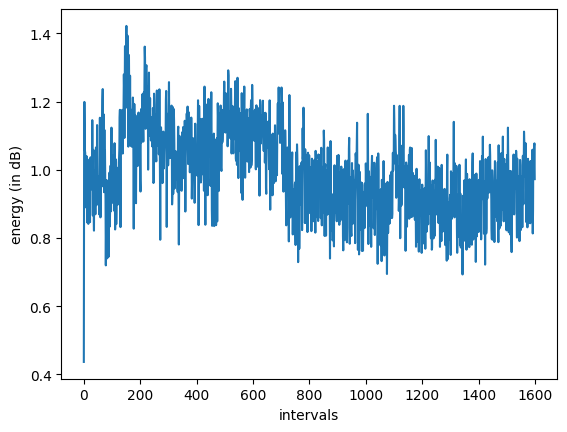

In [18]:
noise_floor = np.sqrt(np.mean(mean_vals**2))
normalized_mean_vals = mean_vals/noise_floor
plt.plot(range(0,num_intervals),normalized_mean_vals)
normalized_mean_vals.max() - normalized_mean_vals.min()
plt.xlabel("intervals")
plt.ylabel("energy (in dB)")

In [19]:
d_mean_vals = np.zeros((num_intervals,1))
for i in range(0,num_intervals-1):
    d_mean_vals[i] = (normalized_mean_vals[i+1] - normalized_mean_vals[i])/interval_width

np.float64(6.699186525179936e-05)

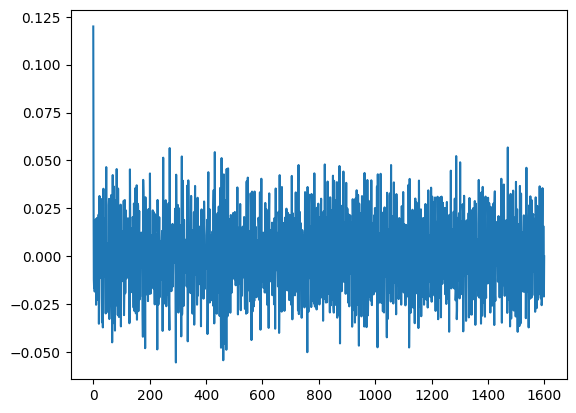

In [20]:
plt.plot(range(0,num_intervals),d_mean_vals)
mean_change = d_mean_vals.mean()
mean_change

<StemContainer object of 3 artists>

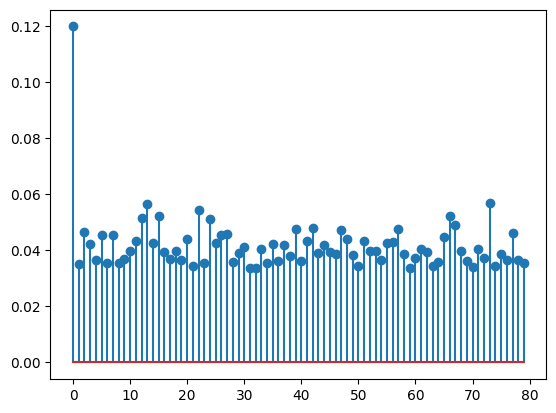

In [32]:
mean_change = np.percentile(d_mean_vals, 95)
above_threshold = d_mean_vals[d_mean_vals > mean_change]

plt.stem(range(0,len(above_threshold)),above_threshold)

In [23]:
threshold = np.percentile(d_mean_vals, 75)  # 75th percentile (adjust as needed)
peaks_mask = d_mean_vals > threshold  # Boolean mask for peaks